In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [10]:
IMAGE_SIZE = [150, 150]

train_path = 'chest_xray/train'
test_path = 'chest_xray/test'

# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False


vgg.get_layer('block5_conv4').trainable = True
vgg.get_layer('block5_conv3').trainable = True
vgg.get_layer('block5_conv2').trainable = True
  
  # useful for getting number of classes
folders = glob('/content/seg_train/seg_train/*')
  

# our layers - you can add more if you want
layer1 = Flatten()(vgg.output)
layer2 = Dense(64, activation='relu')(layer1)
prediction = Dense(len(folders), activation='softmax')(layer2)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)


80142336/80134624 [==============================] - 2s 0us/step


In [11]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
# view the structure of the model
model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer= sgd,
  metrics=['accuracy']
)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('/content/seg_train/seg_train',
                                                 target_size = (150, 150),
                                                 batch_size = 64,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/seg_test/seg_test',
                                            target_size = (150, 150),
                                            batch_size = 64,
                                            class_mode = 'categorical')



Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [13]:
r = model.fit_generator(generator=training_set,
                    validation_data=test_set,
                    epochs = 25,
                    steps_per_epoch=len(training_set),
                    validation_steps=len(test_set))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
220/220 [==============================] - 88s 370ms/step - loss: 0.9924 - accuracy: 0.6052 - val_loss: 0.4334 - val_accuracy: 0.8400
Epoch 2/25
220/220 [==============================] - 80s 364ms/step - loss: 0.4909 - accuracy: 0.8165 - val_loss: 0.3915 - val_accuracy: 0.8530
Epoch 3/25
220/220 [==============================] - 80s 364ms/step - loss: 0.4248 - accuracy: 0.8423 - val_loss: 0.3111 - val_accuracy: 0.8870
Epoch 4/25
220/220 [==============================] - 80s 365ms/step - loss: 0.3818 - accuracy: 0.8616 - val_loss: 0.3291 - val_accuracy: 0.8843
Epoch 5/25
220/220 [==============================] - 80s 364ms/step - loss: 0.3546 - accuracy: 0.8707 - val_loss: 0.3380 - val_accuracy: 0.8793
Epoch 6/25
220/220 [==============================] - 80s 364ms/step - loss: 0.3425 - accuracy: 0.8742 - val_loss: 0.2940 - val_accuracy: 0.8937
Epoch 7/25
220/220 [==============================] - 80s 362ms/step - loss: 0.3297 - accuracy: 0.8804 - val_loss: 0.2964 - val_ac

In [14]:
# save the model's trained weights
model.save_weights('vgg_transfer_trained_wts_sgd_64_BS.h5')
!cp "/content/vgg_transfer_trained_wts_sgd_64_BS.h5" "/content/drive/MyDrive/"

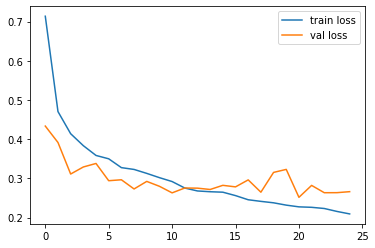

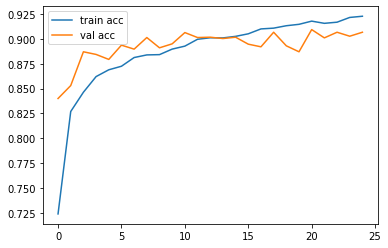

<Figure size 432x288 with 0 Axes>

In [15]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [16]:
pred_datagen = ImageDataGenerator(rescale = 1./255)
prediction_set = pred_datagen.flow_from_directory('/content/seg_pred/seg_pred/',
                                            target_size = (150, 150),
                                            batch_size = 64,
                                            shuffle = False,
                                            class_mode = 'categorical')

pred_original_labels = prediction_set.classes

pred_label = model.predict_generator(prediction_set)


Found 7301 images belonging to 6 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [17]:
# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(pred_label, axis=1)
print('Confusion Matrix')
print(confusion_matrix(prediction_set.classes, y_pred))

Confusion Matrix
[[1060    3    0    0    2   79]
 [   6 1143    2    1    3   11]
 [   6    6 1018  240   53    7]
 [   6    6   70 1152   60    3]
 [   8    4   18   61 1028    9]
 [  74    8    2    3    5 1144]]
